In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

- batch conv function generatoration
- composite functions

0 44.32645797729492
5 28.705698013305664
torch.Size([32, 1, 28, 28])


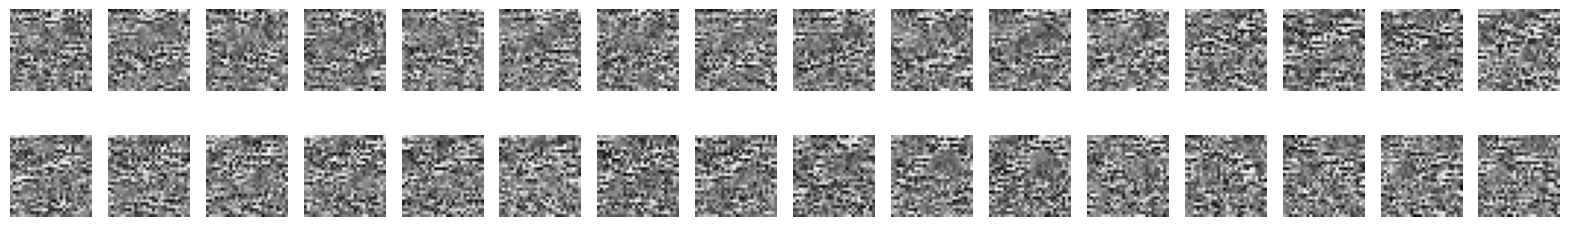

In [7]:
N_IN = 1
N_BATCH = 32
N_SIZE = 28


def generate_random_input_data(batchsize=N_BATCH):
    random_pixels = torch.rand((batchsize, N_IN, N_SIZE, N_SIZE))
    scaled_random_pixels = random_pixels / 8
    scaled_random_pixels.requires_grad = True
    return scaled_random_pixels


def generate_random_weights():
    conv1 = generate_random_weights_for_layer(4, N_IN, 3, 3)
    conv2 = generate_random_weights_for_layer(4, 4, 3, 3)
    conv3 = generate_random_weights_for_layer(4, 4, 3, 3)

    linear_transformation = torch.empty(64, 2)
    linear_transformation = nn.init.xavier_uniform_(
        linear_transformation, gain=nn.init.calculate_gain('relu'))
    linear_transformation.requires_grad = True

    return conv1, conv2, conv3, linear_transformation


def generate_random_weights_for_layer(out_channels, in_channels, w, h):
    w = torch.empty(out_channels, in_channels, w, h)
    w = nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
    w.requires_grad = True
    return w


def my_relu(tensor):
    return torch.max(tensor, torch.zeros_like(tensor))


class WeirdCNN(nn.Module):
    def __init__(self, conv1, conv2, conv3, lt):
        super().__init__()
        self.conv1 = conv1
        self.conv2 = conv2
        self.conv3 = conv3
        self.linear_transformation = lt
        self.max_pool = nn.MaxPool2d(2, 2)
        self.max_pool_odd = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

    def forward(self, input):
        feature_maps_1 = F.conv2d(input, self.conv1)  # 26
        feature_maps_1 = torch.relu(feature_maps_1)
        feature_maps_1 = self.max_pool(feature_maps_1)  # 13

        feature_maps_2 = F.conv2d(feature_maps_1, self.conv2)  # 11
        feature_maps_2 = torch.relu(feature_maps_2)
        feature_maps_2 = self.max_pool_odd(feature_maps_2)  # 6

        feature_maps_3 = F.conv2d(feature_maps_2, self.conv3)  # 4
        feature_maps_3 = torch.relu(feature_maps_3)

        y3 = feature_maps_3.flatten(1)  # should be 16x(4x4x4)


        y = torch.matmul(y3, self.linear_transformation)

        # return torch.softmax(y, dim=1)
        # you don't want to softmax it bc the two things are not mutually exclusive
        return torch.sigmoid(y)


def cursed_predictor(input_data, weights_sequence):
    model = WeirdCNN(*weights_sequence)
    return model(input_data)


def cursed_loss_function(y):
    # so you have like a predefined thing
    # 12 / 12 / 4 / 4
    # 11 / 00 / 10 / 01

    a = y[0:12]
    b = y[12:24]
    c = y[24:28]
    d = y[28:32]

    # a should be 1, 1
    a_loss = torch.sum(-torch.log(a[:, 0])) + torch.sum(-torch.log(a[:, 1]))

    # b should be 0, 0
    b_loss = torch.sum(-torch.log(1-b[:, 0])) + torch.sum(-torch.log(1-b[:, 1]))

    # c should be 1, 0
    c_loss = torch.sum(-torch.log(c[:, 0])) + torch.sum(-torch.log(1-c[:, 1]))

    # d should be 0, 1
    d_loss = torch.sum(-torch.log(1-d[:, 0])) + torch.sum(-torch.log(d[:, 1]))

    return a_loss + b_loss + c_loss + d_loss

    breakpoint()



    # probabilities_top = probabilities[:, 0]

    # sorted_tensor, indices = torch.sort(probabilities_top, descending=True)

    # t8 = sorted_tensor[:N_BATCH // 2]
    # b8 = sorted_tensor[N_BATCH // 2:]

    # top_loss = torch.sum(-torch.log(t8))
    # bottom_loss = torch.sum(-torch.log(1 - b8))

    # return top_loss + bottom_loss



image_tensor = generate_random_input_data()

weights = generate_random_weights()
params = [image_tensor, *weights]
optimizer = torch.optim.Adam(params, lr=0.01)

y = cursed_predictor(image_tensor, weights)

for i in range(10):
    for p in params:
        p.grad = None
    y = cursed_predictor(image_tensor, weights)
    loss = cursed_loss_function(y)
    loss.backward()
    optimizer.step()
    if i % 5 == 0:
        print(i, loss.item())


print(image_tensor.shape)

image_tensor = image_tensor.detach().numpy()
fig, axs = plt.subplots(2, 16, figsize=(20, 3))
for i in range(16):
    # cmap for rgb
    axs[0, i].imshow(image_tensor[i][0], cmap='gray')
    axs[0, i].axis('off')
    # axs[0, i].set_title(f"Prob: {newprobs[i]:.2f}")
for i in range(16, 32):
    axs[1, i-16].imshow(image_tensor[i][0], cmap='gray')
    axs[1, i-16].axis('off')
    # axs[1, i-16].set_title(f"Prob: {newprobs[i]:.2f}")
plt.show()




In [3]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.conv2 = nn.Conv2d(4, 4, 3)
        self.conv3 = nn.Conv2d(4, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4 * 5 * 5, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 4 * 5 * 5)
        x = F.softmax(self.fc1(x), dim=1)
        return x

model = CNN()

# import mnist and train
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainset.data = trainset.data[:1000]
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# train
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = lossfn(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

# test
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

correct_count, all_count = 0, 0
for images, labels in testloader:
    for i in range(len(labels)):
        img = images[i].view(1, 1, 28, 28)
        with torch.no_grad():
            log_ps = model(img)

        ps = torch.exp(log_ps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if true_label == pred_label:
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))




Training loss: 2.3004195243120193
Training loss: 2.2542261481285095
Training loss: 1.9953994825482368
Training loss: 1.7795934528112411
Training loss: 1.7330290004611015
Number Of Images Tested = 10000

Model Accuracy = 0.7267
